In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00
Using device: cuda


100%|██████████| 170M/170M [00:04<00:00, 34.9MB/s]


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]


Epoch 1/50


100%|██████████| 391/391 [04:38<00:00,  1.40it/s]


Train Loss: 1.1305 | Train Acc: 49.21%
Test Loss: 0.5613 | Test Acc: 97.76%
✓ New best model saved!

Epoch 2/50


100%|██████████| 391/391 [04:37<00:00,  1.41it/s]


Train Loss: 1.0722 | Train Acc: 49.81%
Test Loss: 0.5758 | Test Acc: 97.57%

Epoch 3/50


100%|██████████| 391/391 [04:37<00:00,  1.41it/s]


Train Loss: 1.0558 | Train Acc: 53.40%
Test Loss: 0.5748 | Test Acc: 97.08%

Epoch 4/50


100%|██████████| 391/391 [04:37<00:00,  1.41it/s]


Train Loss: 1.0460 | Train Acc: 51.51%
Test Loss: 0.5770 | Test Acc: 96.83%

Epoch 5/50


100%|██████████| 391/391 [04:38<00:00,  1.40it/s]


Train Loss: 1.0657 | Train Acc: 52.11%
Test Loss: 0.5813 | Test Acc: 96.65%

Epoch 6/50


100%|██████████| 391/391 [04:38<00:00,  1.40it/s]


Train Loss: 1.0424 | Train Acc: 53.01%
Test Loss: 0.6057 | Test Acc: 96.56%

Epoch 7/50


100%|██████████| 391/391 [04:39<00:00,  1.40it/s]


Train Loss: 1.0457 | Train Acc: 53.51%
Test Loss: 0.6018 | Test Acc: 96.49%

Epoch 8/50


100%|██████████| 391/391 [04:39<00:00,  1.40it/s]


Train Loss: 1.0509 | Train Acc: 53.79%
Test Loss: 0.5888 | Test Acc: 96.32%
Early stopping triggered after 8 epochs.
Training complete. Best Test Accuracy: 97.76


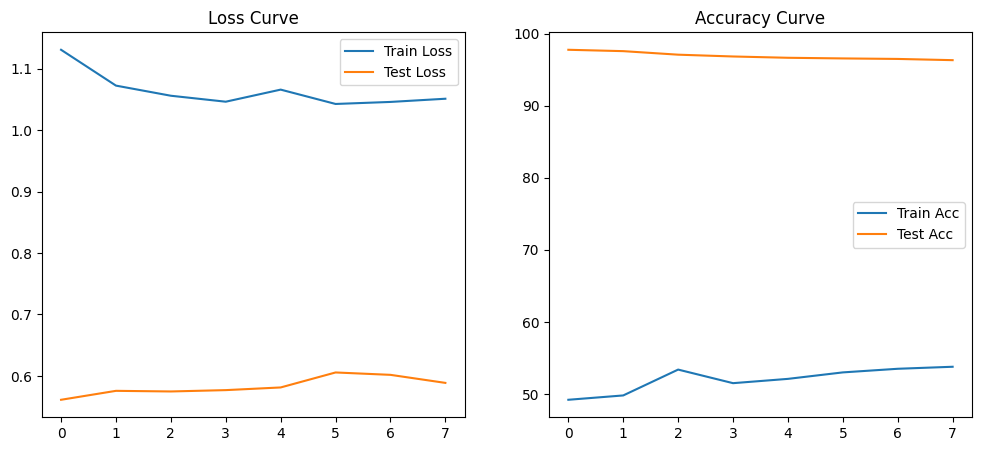

In [2]:
# ================== 1) INSTALL DEPENDENCIES ==================
!pip install --quiet timm
!pip install --quiet torch torchvision

# ================== 2) IMPORTS ==================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ================== 3) CONFIG ==================
CONFIG = {
    'epochs': 50,                  # fewer epochs due to pretrained weights
    'batch_size': 128,
    'lr': 3e-4,
    'weight_decay': 0.05,
    'warmup_epochs': 5,
    'label_smoothing': 0.1,
    'drop_rate': 0.1,
    'attn_drop_rate': 0.1,
    'mixup_alpha': 0.4,
    'cutmix_alpha': 1.0,
    'auto_augment': True,
    'resize': 224,                 # must match pretrained model input
    'early_stop_patience': 7,      # stop if no improvement
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# ================== 4) DATA AUGMENTATION ==================
if CONFIG['auto_augment']:
    transform_train = transforms.Compose([
        transforms.Resize(CONFIG['resize']),
        transforms.RandomCrop(CONFIG['resize'], padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
else:
    transform_train = transforms.Compose([
        transforms.Resize(CONFIG['resize']),
        transforms.RandomCrop(CONFIG['resize'], padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

transform_test = transforms.Compose([
    transforms.Resize(CONFIG['resize']),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

# ================== 5) MODEL ==================
model = timm.create_model(
    'vit_small_patch16_224',   # pretrained ViT-Small
    pretrained=True,
    num_classes=10,
    drop_rate=CONFIG['drop_rate'],
    attn_drop_rate=CONFIG['attn_drop_rate']
)
model.to(device)

# ================== 6) LOSS + OPTIMIZER ==================
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

# Cosine LR scheduler with warmup
def cosine_scheduler(base_lr, epochs, warmup_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = cosine_scheduler(CONFIG['lr'], CONFIG['epochs'], CONFIG['warmup_epochs'])

# ================== 7) MIXUP ==================
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ================== 8) TRAIN & EVALUATE ==================
scaler = torch.amp.GradScaler()  # mixed precision

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        # Apply Mixup
        images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=CONFIG['mixup_alpha'])

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100 * correct / total

# ================== 9) TRAINING LOOP WITH EARLY STOP ==================
best_acc = 0
epochs_no_improve = 0
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(CONFIG['epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_vit_cifar10.pth')
        print("✓ New best model saved!")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= CONFIG['early_stop_patience']:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

print("Training complete. Best Test Accuracy:", best_acc)

# ================== 10) PLOT TRAINING CURVES ==================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()


In [3]:
import timm
print(timm.list_models('*vit*'))


['convit_base', 'convit_small', 'convit_tiny', 'crossvit_9_240', 'crossvit_9_dagger_240', 'crossvit_15_240', 'crossvit_15_dagger_240', 'crossvit_15_dagger_408', 'crossvit_18_240', 'crossvit_18_dagger_240', 'crossvit_18_dagger_408', 'crossvit_base_240', 'crossvit_small_240', 'crossvit_tiny_240', 'davit_base', 'davit_base_fl', 'davit_giant', 'davit_huge', 'davit_huge_fl', 'davit_large', 'davit_small', 'davit_tiny', 'efficientvit_b0', 'efficientvit_b1', 'efficientvit_b2', 'efficientvit_b3', 'efficientvit_l1', 'efficientvit_l2', 'efficientvit_l3', 'efficientvit_m0', 'efficientvit_m1', 'efficientvit_m2', 'efficientvit_m3', 'efficientvit_m4', 'efficientvit_m5', 'fastvit_ma36', 'fastvit_mci0', 'fastvit_mci1', 'fastvit_mci2', 'fastvit_s12', 'fastvit_sa12', 'fastvit_sa24', 'fastvit_sa36', 'fastvit_t8', 'fastvit_t12', 'flexivit_base', 'flexivit_large', 'flexivit_small', 'gcvit_base', 'gcvit_small', 'gcvit_tiny', 'gcvit_xtiny', 'gcvit_xxtiny', 'levit_128', 'levit_128s', 'levit_192', 'levit_256', 